# Análisis de distribución de casos + de Madrid

## Objetivo

El procedimiento de comunicación de datos positivos de Covid de la Comunidad de Madrid se basa en comunicar un número total diarios, primera página de este pdf por ejemplo, mencionándose, a continuación, los que corresponden al día anterior. El resto se distribuyen entre días pasados. Nos preguntamos como se hace ese reparto, hasta cuando se "reparten" esos positivos, ¿cuánto hacia atrás se están llevando?, qué equivale a decir: con qué retraso se están asignando esos casos, de hoy por ejemplo, a sus fechas reales?.
En este trabajo vamos a intentar responder a esa pregunta

## Pasos a seguir

1. Descargaremos los ficheros pdf del repositorio de la Comunidad de Madrid, desde el 01 de Septiembre. Este es, como ejemplo, el [fichero](https://www.comunidad.madrid/sites/default/files/doc/sanidad/200901_cam_covid19.pdf)  del 1 de Septiembre.
2. Leeremos esos ficheros buscando las tablas de acumulado, que aparecen en la página 2 y 3 de ese documento.
3. Construiremos, con esa información, la "visión" de casos que se ha tenido en cada uno de los días desde Septiembre, guardándolas como columnas de un `pandas`
4. A continuación calcularemos los incrementales diarios de cada día, es decir los positivos comunicados en el documento de un día en concreto: a qué días se están asignando.
5. En este punto tendremos un `pandas`con los datos de cada día de publicación en columna, y cada fila representa el día al que se asocia.
6. Por último desplazaremos cada columna para que cada fila represente de manera relativa días de diferencia con el de publicación (así hablaremos de que un dato presentado en día `t` se ha asignado a un día `t-3` por ejemplo, tres días anteriores.
7. Finalmente preparemos un gráfico para visualizar este comportamiento.

Para los pasos 1 y 2 he utilizado el script escrito por [@alfonsotwr](https://twitter.com/alfonsotwr) , disponible en su [github](https://github.com/alfonsotwr/snippets/tree/master/covidia-cam). Todo el código de esos pasos es suyo. 
Manos a la obra

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [1]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

In [2]:
expnumber = re.compile(r'^ *(\d+(?: ?\. ?\d+)*)(?:[^\d/]|\s|\(|$|\.[^\d/]|\.\s|\.$)', re.M)
expfecha = re.compile(r'(\d\d)/(\d\d)/(\d\d\d\d)') #fechas
expacum = re.compile(r'\n2 \n7 \n11 \n[\d \n]+') #acumulados, 2,7,11 son los primeros datos de la serie
expnumber2 = re.compile(r'\d\d\d\d\d+')

Definimos variables que nos ayuden en la gestión de los nombres de los ficheros.

In [3]:
URL_TPL = 'https://www.comunidad.madrid/sites/default/files/doc/sanidad/{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL = '{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL_txt = '{:02d}{:02d}{:02d}_cam_covid19.txt'
datadir='data/'

In [11]:
ALWAYS_UPDATE = True
def descarga(url, fn, isbinary=False, isascii=False, isbackup=False,
             prevpage=None):
    #función para descargar el fichero depositado en url y que guardamos con 
    #nombre fn
    
    
    today = dt.date.today()

    ret = True

    if pth.isfile(fn):
        modifiedTime = pth.getmtime(fn)
        changed = dt.datetime.fromtimestamp(modifiedTime).date()

        if isbackup:
            basename = pth.basename(fn)
            rootfn, ext = pth.splitext(basename)
            dirname = pth.dirname(fn)
            changedstr = str(changed)

            backupfn = pth.join(dirname, 'backup',
                                rootfn + '-' + changedstr + ext)
            print('Backup: {} -> {}'.format(fn, backupfn))
            copyfile(fn, backupfn)


    if not pth.isfile(fn) or changed != today or ALWAYS_UPDATE:
        print('Descargando:', url)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        with requests.Session() as s:
            if prevpage:
                s.get(prevpage, headers=headers)
            r = s.get(url, headers=headers)
        if r.status_code == requests.codes.ok:
            if isbinary:
                with open(fn, 'wb') as fp:
                    fp.write(r.content)
            elif isascii:
                content = r.content
                text = r.content.decode('ascii', 'ignore')
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(text)
            else:
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(r.text)
        else:
            print('ERROR', r.status_code, 'descargando:', fn)
            ret = False

    return ret

In [12]:
# Extract PDF text using PDFMiner. Adapted from
# http://stackoverflow.com/questions/5725278/python-help-using-pdfminer-as-a-library

def pdf_to_text(pdfname, pagenum=None):

    # PDFMiner boilerplate
    rsrcmgr = PDFResourceManager()
    sio = StringIO()
    laparams = LAParams()
    device = None
    try:
        device = TextConverter(rsrcmgr, sio, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # Extract text
        with open(pdfname, 'rb') as fp:
            for i, page in enumerate(PDFPage.get_pages(fp)):
                if pagenum is None or pagenum == i:
                    interpreter.process_page(page)

        # Get text from StringIO
        text = sio.getvalue()
    finally:
        # Cleanup
        sio.close()
        if device is not None:
            device.close()

    return text

In [14]:
# descargamos los ficheros pdf desde 1 de Septiembre hasta hoy
# sacado del script de @alfonsotwr mencionado
today = dt.date.today()

un_dia = dt.timedelta(days=1)
tomorrow = today+un_dia
ayer= today-un_dia
desde = dt.date(year=2020,month=9,day=1)

date_array = np.arange(today-un_dia-un_dia-un_dia-un_dia, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')
date_array_download = np.arange(today-un_dia-un_dia-un_dia, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array_download:
    pdfdir = 'data/'
    dia_dt = dia.item()
    if dia_dt.weekday() in [6]: #quitamos sábado
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    url = URL_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    ret = descarga(url, fn, isbinary=True)
    time.sleep(1)
    if not ret:
        changed = False
        if dia_dt == dt.date(2020, 9, 2):  # special cases
                url = url.replace('/doc/sanidad', '')
                changed = True
        if changed:
            descarga(url, fn, isbinary=True)
            time.sleep(1)

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201123_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201124_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201125_cam_covid19.pdf


In [15]:
for dia in date_array:
    print (dia)

2020-11-21
2020-11-22
2020-11-23
2020-11-24
2020-11-25


In [20]:
#Creamos los txt con los datos
#basado en el script de @alfonsotwr mencionado
desde = dt.date(year=2020,month=11,day=1)

date_array = np.arange(desde, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array:
    dia_dt = dia.item()
    #if (dia_dt.weekday() in [6]) or (dia_dt.month ==10 and dia_dt.day == 12):
    if (dia_dt.month ==10 and dia_dt.day == 12):
        continue
    
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    
    #datos de la primera página del pdf
    print('Creating:', fn1)
    page1 = pdf_to_text(fn, pagenum=0)
    #with open(fn1, 'w', encoding='utf-8') as fp:
    with open(fn1, 'w') as fp:    
        fp.write(page1)
    
    #datos de la segunda página del pdf
    print('Creating:', fn2)
    page2 = pdf_to_text(fn, pagenum=1)
    #with open(fn2, 'w', encoding='utf-8') as fp:
    with open(fn2, 'w') as fp:     
        fp.write(page2)
    
    #datos de la tercera página del pdf
    print('Creating:', fn3)
    page3 = pdf_to_text(fn, pagenum=2)
    #with open(fn3, 'w', encoding='utf-8') as fp:
    with open(fn3, 'w') as fp:
        fp.write(page3)

Creating: data/201101_cam_covid19_1.txt
Creating: data/201101_cam_covid19_2.txt
Creating: data/201101_cam_covid19_3.txt
Creating: data/201102_cam_covid19_1.txt
Creating: data/201102_cam_covid19_2.txt
Creating: data/201102_cam_covid19_3.txt
Creating: data/201103_cam_covid19_1.txt
Creating: data/201103_cam_covid19_2.txt
Creating: data/201103_cam_covid19_3.txt
Creating: data/201104_cam_covid19_1.txt
Creating: data/201104_cam_covid19_2.txt
Creating: data/201104_cam_covid19_3.txt
Creating: data/201105_cam_covid19_1.txt
Creating: data/201105_cam_covid19_2.txt
Creating: data/201105_cam_covid19_3.txt
Creating: data/201106_cam_covid19_1.txt
Creating: data/201106_cam_covid19_2.txt
Creating: data/201106_cam_covid19_3.txt
Creating: data/201107_cam_covid19_1.txt
Creating: data/201107_cam_covid19_2.txt
Creating: data/201107_cam_covid19_3.txt
Creating: data/201108_cam_covid19_1.txt
Creating: data/201108_cam_covid19_2.txt
Creating: data/201108_cam_covid19_3.txt
Creating: data/201109_cam_covid19_1.txt


In [24]:
#creamos los ficheros csv a partir de los ficheros txt creados antes.
#basado en el script de @alfonsotwr mencionado

csvfn = datadir + 'madrid-series.csv'
today = dt.date.today()
tomorrow=today+un_dia
un_dia = dt.timedelta(days=1)
desde = dt.date(year=2020,month=11,day=1)

date_array = np.arange(desde, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array:
    df = pd.DataFrame()
    pdfdir = 'data/'
    dia_dt = dia.item()
    #if dia_dt.weekday() in [6]  or (dia_dt.month ==10 and dia_dt.day == 12):
    if (dia_dt.month ==10 and dia_dt.day == 12):   
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn2.replace('_2.txt', '_3.txt')
    print(fn2)
    #with open(fn2, encoding='utf-8') as fp:
    with open(fn2) as fp:
        text = fp.read()

    m = expacum.search(text)

    assert m, 'Debe ajustarse expacum con los primeros valores'

    accum = [int(x) for x in m.group().split()]

    dates = []
    for m in expfecha.finditer(text):
        dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                    int(m.group(1))))
    #añadido para solucionar 2 nov
    #https://github.com/alfonsotwr/snippets/commit/cc7461472eb494c624bbfe15c306925473533e0c#diff-6ce49d64b0ad3c7009e50b88fb31aacbd74a514dfcede8d70633e6ab4c71701f
    dates = sorted(dates)
    #accum2 = [int(x.group()) for x in expnumber2.finditer(text)
    #        if int(x.group()) > accum[-1]]
    
    accum2 = sorted(int(x.group()) for x in expnumber2.finditer(text)
                     if int(x.group()) > accum[-1])
    accum += accum2

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

    print(fn3)
    #with open(fn3, encoding='utf-8') as fp:
    with open(fn3) as fp:   
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                      int(m.group(1))))
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    
    
    
    accum += sorted(accum2)

    # assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

    sr = pd.Series(accum, index=dates).sort_index()
    sr.name = 'PCR+'
    sr.index.name = 'Fecha'
    df2 = sr.to_frame()

    #if df.index[-1] != df2.index[-1] + dt.timedelta(1):
    #    raise RuntimeError('Última fecha de las tablas no coincide')

    # pd.set_option('display.max_rows', None)
    # print(sr)
    # print(sr.diff())
    assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
    assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

    csvfn = datadir + 'madrid_pcr_' + dia.item().strftime('_%d_%m')+'.csv'
    print('Escribiendo', csvfn)
    df2.to_csv(csvfn, line_terminator='\r\n')

data/201101_cam_covid19_2.txt
data/201101_cam_covid19_3.txt
Escribiendo data/madrid_pcr__01_11.csv
data/201102_cam_covid19_2.txt
data/201102_cam_covid19_3.txt
Escribiendo data/madrid_pcr__02_11.csv
data/201103_cam_covid19_2.txt
data/201103_cam_covid19_3.txt
Escribiendo data/madrid_pcr__03_11.csv
data/201104_cam_covid19_2.txt
data/201104_cam_covid19_3.txt
Escribiendo data/madrid_pcr__04_11.csv
data/201105_cam_covid19_2.txt
data/201105_cam_covid19_3.txt
Escribiendo data/madrid_pcr__05_11.csv
data/201106_cam_covid19_2.txt
data/201106_cam_covid19_3.txt
Escribiendo data/madrid_pcr__06_11.csv
data/201107_cam_covid19_2.txt
data/201107_cam_covid19_3.txt
Escribiendo data/madrid_pcr__07_11.csv
data/201108_cam_covid19_2.txt
data/201108_cam_covid19_3.txt
Escribiendo data/madrid_pcr__08_11.csv
data/201109_cam_covid19_2.txt
data/201109_cam_covid19_3.txt
Escribiendo data/madrid_pcr__09_11.csv
data/201110_cam_covid19_2.txt
data/201110_cam_covid19_3.txt
Escribiendo data/madrid_pcr__10_11.csv
data/20111

A continuación vamos a generar el pandas con todas la información que hemos conseguido de los ficheros pdf

In [30]:
desde = dt.date(year=2020,month=9,day=1)

date_array = np.arange(desde, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')
df=pd.DataFrame() #creamos un pandas vacío para trabajar

for dia in date_array[::]: #iteramos sobre todo el tiempo de análisis, desde 1 Sept
    dia_dt = dia.item() # date_array es un array de tiempo de numpy, con item() pasamos a datetime
    if dia_dt.weekday() in [5,6] or (dia_dt.month ==10 and dia_dt.day == 12): # en los fines de semana no se publican datos
        continue
    #construimos el nombre del ficher csv en el que hemos guardado la info.
    nombre_csv=datadir+'madrid_pcr__{:02d}_{:02d}.csv'.format(dia_dt.day,dia_dt.month)
    
    #leemos el csv en un pandas df1
    df1=pd.read_csv(nombre_csv).set_index('Fecha')
    #asigbamos como nombre de columna el día en el que se publica (dia)
    nombre_columna='{:02d}-{:02d}-{:02d}'.format(dia_dt.year,dia_dt.month,dia_dt.day)
    df1.columns=[nombre_columna]
    
    #concatenamos es pandas recién leído con el principal
    df = pd.concat([df,df1], axis=1)
#invertimos el orden de las columnas para tener a la izquierda la fecha más antigua
#df = df[df.columns[::-1]]
#df = df.diff() #resta una fila de la anterior
#df.fillna(0,inplace=True)
#df = df.diff(axis=1) #resta una columna de la anterior


In [31]:
date_array

array(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
       '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
       '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
       '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
       '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
       '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
       '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
       '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
       '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18',
       '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
       '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
       '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
       '2020-10-31', '2020-11-01', '2020-11-02', '2020-

In [32]:
df.tail(60)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,258032.0,258390.0,258956.0,259248.0,259583.0,259938.0,260198.0,260656.0,260912.0,261194
2020-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,258898.0,259258.0,259827.0,260119.0,260454.0,260810.0,261072.0,261532.0,261789.0,262072
2020-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,260576.0,260944.0,261518.0,261811.0,262148.0,262506.0,262770.0,263232.0,263490.0,263776
2020-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,264605.0,264983.0,265565.0,265862.0,266206.0,266568.0,266835.0,267301.0,267563.0,267851
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,267968.0,268347.0,268938.0,269240.0,269588.0,269955.0,270229.0,270702.0,270966.0,271257
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,270803.0,271188.0,271789.0,272095.0,272449.0,272819.0,273095.0,273578.0,273844.0,274137
2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,274431.0,274821.0,275429.0,275736.0,276094.0,276466.0,276747.0,277239.0,277510.0,277807
2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,275338.0,275730.0,276340.0,276649.0,277008.0,277380.0,277662.0,278156.0,278428.0,278725
2020-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,275779.0,276172.0,276784.0,277093.0,277453.0,277825.0,278109.0,278603.0,278875.0,279172
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,277827.0,278225.0,278847.0,279159.0,279524.0,279899.0,280184.0,280681.0,280959.0,281265


Hagamos comprobaciones para asegurar que los datos son correctos: 

Queremos saber cuantos casos había en el día 3 Septiembre, vistos desde el día 10 septiembre [aquí](https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf)

In [33]:
df.loc['2020-07-03',df.columns=='2020-09-10'].values[0]

81795.0

In [34]:
df.loc['2020-07-03',df.columns=='2020-09-10']-df.loc['2020-07-02',df.columns=='2020-09-10']

2020-09-10    154.0
dtype: float64

In [35]:
df.loc['2020-08-17',df.columns=='2020-09-02'] #este funciona restando filas

2020-09-02    104157.0
Name: 2020-08-17, dtype: float64

In [36]:
df.loc['2020-08-17',df.columns=='2020-09-02']

2020-09-02    104157.0
Name: 2020-08-17, dtype: float64

Lo mismo con el día [02/09](https://www.comunidad.madrid/sites/default/files/200902_cam_covid19.pdf). Resultado también correcto:

In [39]:
fecha_menos=(dt.datetime.strptime('2020-09-01','%Y-%m-%d')-catorce_dias).strftime('%Y-%m-%d')

In [38]:
catorce_dias=dt.timedelta(days=14)

In [40]:
df.loc['2020-09-01',df.columns=='2020-09-02']-df.loc[fecha_menos,df.columns=='2020-09-02']

2020-09-02    27315.0
dtype: float64

In [41]:
df_ratio = pd.DataFrame(index=df.columns[1:])
df_ratio['AI14']=0
df_ratio['AI14_7']=0

In [42]:
def calculo_AI(x):
    catorce_dias=dt.timedelta(days=14)
    un_dia=dt.timedelta(days=1)
    #print (x.name)
    fecha = dt.datetime.strptime(x.name,'%Y-%m-%d')
    ayer_dt = (fecha-un_dia)
    ayer = ayer_dt.strftime('%Y-%m-%d')
    inicio = (ayer_dt-catorce_dias).strftime('%Y-%m-%d')
    valor= df.loc[ayer,df.columns==x.name]-df.loc[inicio,df.columns==x.name]
    
    print (valor.values[0])
    return valor.values[0]

In [43]:
def calculo_AI_7(x):
    catorce_dias=dt.timedelta(days=14)
    un_dia=dt.timedelta(days=1)
    siete_dias=dt.timedelta(days=7)
    fecha = dt.datetime.strptime(x.name,'%Y-%m-%d')
    fecha_fin_dt = (fecha-siete_dias)
    fecha_fin = fecha_fin_dt.strftime('%Y-%m-%d')
    
    inicio = (fecha_fin_dt-catorce_dias).strftime('%Y-%m-%d')
    valor= df.loc[fecha_fin,df.columns==x.name]-df.loc[inicio,df.columns==x.name]
    
    print (valor.values[0])
    return valor.values[0]

In [44]:
df_ratio.loc[:,'AI14_7']=df_ratio.apply(calculo_AI_7,axis=1)

27925.0
28728.0
29389.0
31382.0
31871.0
32160.0
32630.0
32972.0
34583.0
35226.0
36369.0
37489.0
39020.0
41579.0
43431.0
45232.0
47016.0
48911.0
49965.0
50319.0
50494.0
50464.0
49391.0
47801.0
45995.0
44074.0
41674.0
38093.0
35018.0
33294.0
31900.0
30066.0
28113.0
26671.0
26073.0
26047.0
25150.0
24946.0
24304.0
23846.0
23319.0
22788.0
23961.0
23341.0
22619.0
22189.0
21716.0
20175.0
19633.0
19300.0
19011.0
18606.0
17643.0
17148.0
16849.0
16362.0
15768.0
16349.0
15675.0
14959.0


In [45]:
df_ratio.loc[:,'AI14']=df_ratio.apply(calculo_AI,axis=1)

27315.0
27058.0
26718.0
29933.0
31326.0
30180.0
30624.0
30884.0
35133.0
37054.0
36523.0
37553.0
38838.0
42212.0
43812.0
42708.0
41997.0
40650.0
44447.0
44806.0
41896.0
39715.0
38064.0
34732.0
34926.0
32663.0
30987.0
29062.0
26255.0
24686.0
23882.0
23880.0
22957.0
22491.0
22377.0
21936.0
21438.0
20705.0
21984.0
21617.0
20974.0
20553.0
19843.0
18133.0
17740.0
17476.0
17241.0
16756.0
15787.0
15494.0
15357.0
15016.0
14268.0
14914.0
14272.0
13601.0
13029.0
12234.0
12265.0
11677.0


In [46]:
df_ratio

,AI14,AI14_7
2020-09-02,27315.0,27925.0
2020-09-03,27058.0,28728.0
2020-09-04,26718.0,29389.0
2020-09-07,29933.0,31382.0
2020-09-08,31326.0,31871.0
2020-09-09,30180.0,32160.0
2020-09-10,30624.0,32630.0
2020-09-11,30884.0,32972.0
2020-09-14,35133.0,34583.0
2020-09-15,37054.0,35226.0


In [47]:
df

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25
2020-02-25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2
2020-02-26,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7
2020-02-27,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11
2020-02-28,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24
2020-02-29,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,...,34.0,34.0,34.0,34.0,34.0,34.0,35.0,35.0,35.0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348715.0,349375.0,350059
2020-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348873.0,349564.0,350296
2020-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348954.0,349670.0,350430
2020-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350273.0,351106


In [48]:
ai14 = pd.DataFrame(index=df.index[:],columns=df.columns)



In [49]:
ai14

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
poblacion_madrid = 6642000

In [51]:
def test(x):
    return x.diff(periods=14)

In [52]:
ai14.loc[:,:]=df.apply(test)

In [53]:
ai14.index = pd.to_datetime(ai14.index)
ai14=ai14/poblacion_madrid*100000

In [54]:
ai14.tail(10)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25
2020-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,214.814815,219.993978,225.986149,229.147847,232.113821,237.172538,238.587775,240.123457
2020-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,224.540801,231.737428,236.224029,239.942788,246.145739,247.922313,249.713942
2020-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,214.875038,221.288768,226.242096,233.830172,235.998193,237.940379
2020-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,204.772659,210.975610,220.355315,222.975008,225.218308
2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,196.160795,207.181572,210.448660,213.429690
2020-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.426980,196.537188,200.331226
2020-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.166215,192.713038,197.139416
2020-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.191509,189.099669,193.887383
2020-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.658235,190.439627
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.805480


In [55]:
ai14.loc['2020-09-02','2020-10-23']

552.1680216802168

In [56]:
ai14_ratio = pd.DataFrame(index=df.index[:],columns=df.columns)

In [57]:
def calculo_ratio(x):
    return x.pct_change(periods=7,fill_method='backfill').add(1)

In [58]:
ai14_ratio.loc[:,:]=ai14.apply(calculo_ratio,axis=0)

In [59]:
ai14_ratio.tail(60)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.971743,0.972149,0.972539,0.972730,0.972725,0.972993,0.972996,0.973032,0.973192,0.973082
2020-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.961133,0.961514,0.961918,0.962061,0.962067,0.962329,0.962304,0.962391,0.962574,0.962451
2020-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.943851,0.944342,0.944753,0.944854,0.944844,0.945141,0.945129,0.945256,0.945357,0.945302
2020-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.907798,0.908270,0.908730,0.908775,0.908784,0.909000,0.909001,0.908929,0.909066,0.908962
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.875282,0.875516,0.876063,0.876242,0.876199,0.876177,0.876243,0.876193,0.876351,0.876247
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.836924,0.837233,0.837631,0.837830,0.837741,0.837763,0.837843,0.838036,0.838185,0.838138
2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.786795,0.787120,0.787570,0.787666,0.787635,0.787661,0.787878,0.788121,0.788309,0.788399
2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.781111,0.781468,0.781929,0.781978,0.781945,0.781891,0.782081,0.782343,0.782571,0.782666
2020-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.776956,0.777318,0.777795,0.777909,0.777915,0.777812,0.778008,0.778243,0.778476,0.778619
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.784241,0.784503,0.784932,0.785056,0.785108,0.784983,0.785191,0.785442,0.785728,0.785940


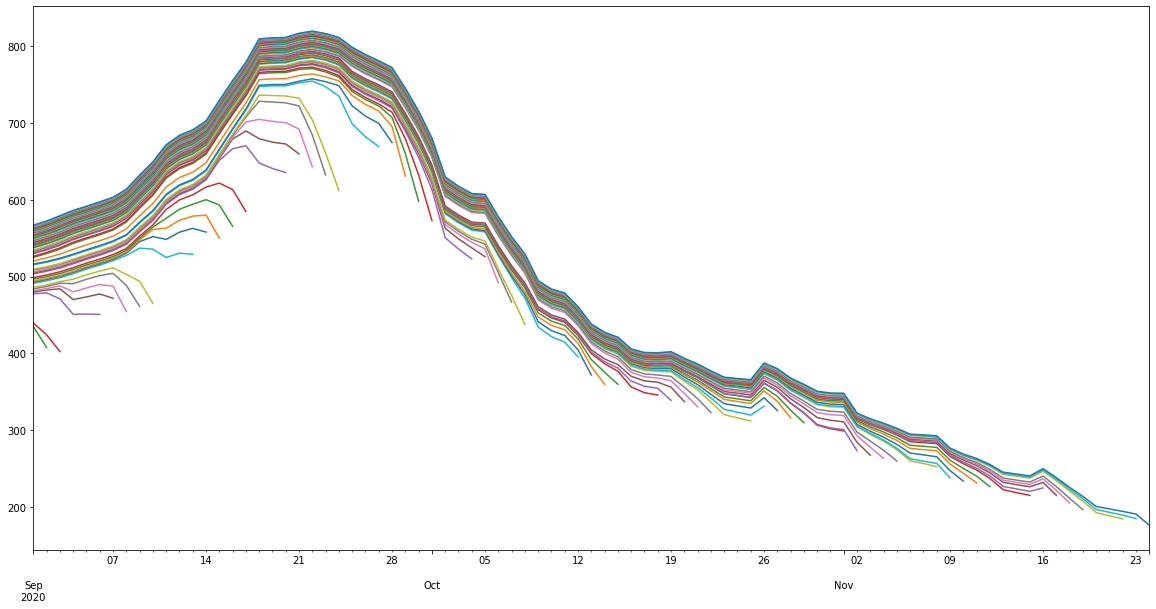

In [60]:
for indice in ai14_ratio:
    ai14.loc['2020-09-01':,indice].plot(figsize=(20,10),label=indice,legend=False)

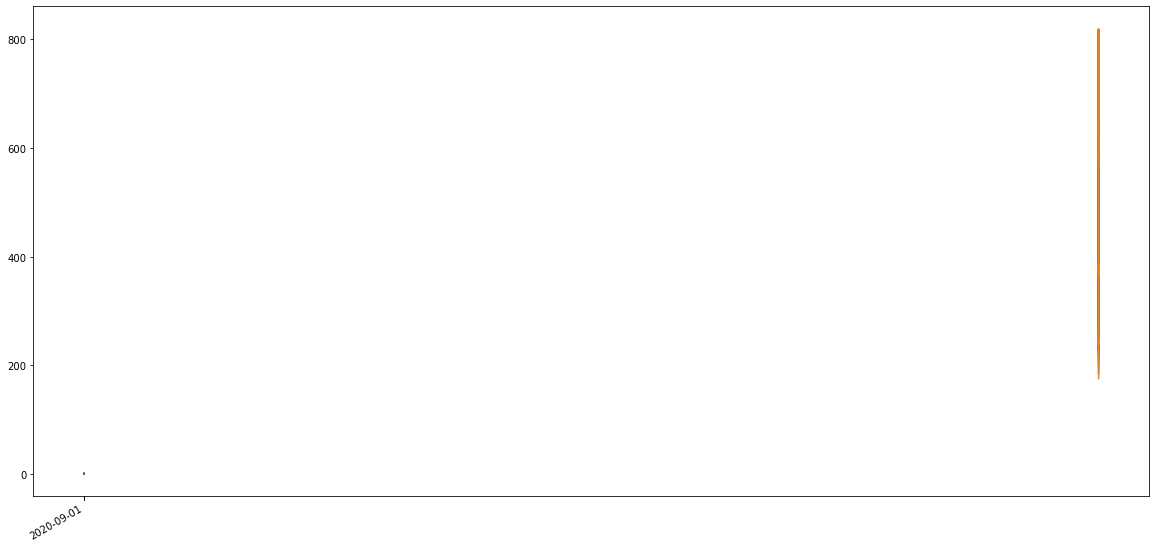

In [61]:
for indice in ai14_ratio:
    ai14_ratio.loc['2020-09-01':,indice].plot(figsize=(20,10),label=indice,legend=False)
    ai14.loc['2020-09-01':,indice].plot(figsize=(20,10),label=indice,legend=False)

In [62]:
color_rojo = sns.color_palette("bright", 10)[3]
color_verde = sns.color_palette("muted", 10)[2]
color_amarillo = sns.color_palette("YlOrRd", 10)[1]
color_eje_x = 'navy'
color_eje_y1 ='navy'
color_eje_y2 = sns.color_palette('rocket')[2]
eje_X = ' Incidencia Acumulada a 14 días'
eje_Y1 = 'IA14'
eje_Y2 = 'ratio IA14 a 7 días'

titulo='Madrid: Evolución de la IA14 y su ratio con respecto a siete días anteriores \n'
titulo+='Cada curva muestra la IA14 y el ratio calculado con la información de esa fecha'

y0, y1 = (0,1000)
x0, x1 = dt.datetime.strptime('2020-09-01','%Y-%m-%d').toordinal(),ai14.index[-1].toordinal()
# x0=pd.Timestamp('2020-09-01')
# x1=pd.Timestamp('2020-10-30')
#rango = np.arange(x0,x1,1)
def formateamos_eje(ax):
    '''
    función que formatea el gráfico con las características que queramos
    '''
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=8, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.set_xlim(x0,x1)
    ax.set_ylim(y0,y1)
    

def init():
    '''
    función que inicia el eje en el que dibujamos las barras
    
    '''
    ax.clear()
    ax2.clear()
    #ax.set_xlim(x0,x1)
    #ax.set_ylim(y0,y1)
    formateamos_eje(ax)
    #ax.set_ylim(.2, 6.8)



def update(i):
    '''
    Función invocada para ir regenerando el gráfico, 
    Va actualizando añadiendo días (i incrementandose).
    
    '''
    for elemento in lista_elementos:
        elemento.remove()
    lista_elementos[:] = []
    
    
    #print (i)
    #ax.set_xlim('2020-09-01',ai14.index[-1])
    #ax.set_ylim(y0,y1)
    #x0,x1=ax.get_xlim()
    #colores = sns.color_palette("YlOrBr",i)
    colores1 = sns.color_palette("Blues",i)
    colores2 = sns.color_palette("rocket_r",i)
   
    for j,indice in enumerate(ai14_ratio.columns[:i]):
        curva = ax.plot(ai14.index[ai14.index>='2020-09-01'],
                ai14.loc[ai14.index>='2020-09-01',indice],color=colores1[j],linewidth=.2)
        ax.set_xlim(x0,x1)
        ax.set_ylim(y0,y1)
        curva2 = ax2.plot(ai14.index[ai14.index>='2020-09-01'],
                ai14_ratio.loc[ai14.index>='2020-09-01',indice],color=colores2[j],linewidth=.1)
        #ax2.set_xlim(x0,x1)
        ax2.set_ylim(0,2)
        #lista_elementos.append(curva)
   
    #ax.plot(ai14.index[ai14.index>='2020-09-01'],
    #            ai14.loc[ai14.index>='2020-09-01',ai14.columns[i]])
    ax.xaxis.set_major_locator(DayLocator([1,10,20]))
    majorFmt = DateFormatter('%-d-%b')
    ax.xaxis.set_major_formatter(majorFmt)
    ax.grid(True,axis='both')
    #ax.yaxis.set_tick_params(labelsize=0,labelcolor=color_eje,width=0)
    ax.set_ylabel(eje_Y1,size=20,color=color_eje_y1)
    #ax.set_xlabel(eje_X,size=14,color='black')
    #ax4.set_yticks([])
    ax.yaxis.set_tick_params(labelsize=16,labelcolor=color_eje_y1,width=0)
        
    #ax.yaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_tick_params(labelsize=10,labelcolor=color_eje_x)
    #ax.set_xlim(x0,x1)
    ax2.set_ylabel(eje_Y2,size=20,color=color_eje_y2)
    ax2.yaxis.set_tick_params(labelsize=12,labelcolor=color_eje_y2,width=0)
    ax.set_title(titulo,fontsize=14)
    ax2.axhline(1,color=color_eje_y2)
    ax2.set_yticks([0,.5,1,1.5,2])

lista_elementos = []    

fig = plt.Figure(figsize=(10, 5), dpi=144)

ax = fig.add_subplot()
ax2 = ax.twinx()

#ax2.axhline(1,color=color_eje_y2)
#ax2.set_yticks([0,.5,1,1.5,2])

anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(ai14.index[ai14.index>='2020-09-01']), 
                     interval=150, repeat=False)
plt.show()
#ax.clear()
#ax2.clear()
#con interval puedes modular la velocidad del video, más alto --> mas lento

In [63]:
from IPython.display import HTML
html = anim.to_html5_video()
HTML(html)

In [147]:
ax.clear()
ax2.clear()

In [64]:
anim.save('videos/evolucion_ai14_mad.mp4',fps=30, extra_args=['-vcodec', 'libx264'],codec='h264')